# Лабораторна робота №4

Бригада №3, КА-61м
- Краснощок Ілля
- Одобеску Владислав
- Фатенко Владислав
- Шевченко Тарас

## Завдання

Вивчити теоретичні основи методу аналізу ієрархій.

Побудувати мультиплікативну матрицю парних порівнянь (МПП) оцінювання альтернатив рішень за одним критерієм за умови, що експерт дає оцінки у фундаментальній шкалі.

Розрахувати глобальні ваги елементів ієрархії для повної ієрархії з $p$ рівнями, $p>2$, яка задається вектором $m=\{(m_k)|k=1,\dots,p\}$, де $m_k \in \mathbb{N}$ - кількість елементів на $k$-му рівні ієрархії. Для цього:

- зчитати з файлу кількість рівнів ієрархії та кількість елементів на кожному рівні,
- зчитати з файлу матриці парних порівнянь елементів ієрархії,
- розрахувати один з показників узгодженості (згідно з варіантом) матриць парних порівнянь та зробити висновки щодо рівня неузгодженості,
- розрахувати локальні ваги елементів ієрархії одним з методів парних порівнянь (згідно з варіантом),
- розрахувати глобальні ваги елементів ієрархії одним з методів синтезу (згідно з варіантом).

Зробити висновки по роботі

Дати відповіді на контрольні питання, наведені в кінці роботи.

## Виконання роботи

### Побудова МПП
Розглядається задача №3:

> Нехай інвестор оцінює акції деякої компаній і хоче спрогнозувати, яким буде розподіл ймовірностей зміни ціни на них. Він розглядає наступні можливі варіанти зміни ціни: впаде на 20%, впаде на 10%, залишиться незмінною, зросте на 10%. Використовуючи результати фундаментального аналізу, парні порівняння варіантів зміни ціни наступні:
- імовірність події, що ціна акцій зросте на 10% ненабагато перевищує імовірність події, що ціна акцій залишиться незмінною на протязі визначеного періоду часу і суттєво перевищує імовірності того, що ціна акцій впаде як на 10%, так і на 20%;
- імовірність події, що ціна акцій залишиться незмінною ненабагато перевищує імовірності подій, що ціна акцій впаде як на 10%, так і на 20%;
- імовірність події, що ціна акцій впаде на 10% ненабагато перевищує імовірність події, що ціна акцій впаде на 20%.

Таблично умову можна представити у наступному вигляді:

<table>
<tr>
<th>Варіанти зміни ціни</th>
<th>Впаде на 20%</th>
<th>Впаде на 10%</th>
<th>Залишиться незмінною</th>
<th>Зросте на 10%</th>
</tr>
<tr>
<td>Впаде на 20%</td>
<td>-</td><td>-</td><td>-</td><td>-</td>
</tr>
<tr>
<td>Впаде на 10%</td>
<td>ненабагато перевищує</td><td>-</td><td>-</td><td>-</td>
</tr>
<tr>
<td>Залишиться незмінною</td>
<td>ненабагато перевищує</td><td>ненабагато перевищує</td><td>-</td><td>-</td>
</tr>
<tr>
<td>Зросте на 10%</td>
<td>суттєво перевищує</td><td>суттєво перевищує</td><td>ненабагато перевищує</td><td>-</td>
</tr>
</table>

Відповідно до фундаментальної шкали експертних суджень, "суттєво перевищує" відповідає 5, а "ненабагато перевищує" відповідає 3. Тоді отримуємо наступну МПП:

<table>
<tr>
<th>Варіанти зміни ціни</th>
<th>Впаде на 20%</th>
<th>Впаде на 10%</th>
<th>Залишиться незмінною</th>
<th>Зросте на 10%</th>
</tr>
<tr>
<td>Впаде на 20%</td>
<td>1</td><td>1/3</td><td>1/3</td><td>1/5</td>
</tr>
<tr>
<td>Впаде на 10%</td>
<td>3</td><td>1</td><td>1/3</td><td>1/5</td>
</tr>
<tr>
<td>Залишиться незмінною</td>
<td>3</td><td>3</td><td>1</td><td>1/3</td>
</tr>
<tr>
<td>Зросте на 10%</td>
<td>5</td><td>5</td><td>3</td><td>1</td>
</tr>
</table>

### Розрахування глобальних ваг елементів ієрархії

Розглядається варіант №3:
- $p=3$
- $m=\{2,3,4\}$
- метод головного власного вектору, показник узгодженості CR
- мультиплікативний метод розрахунку глобальних ваг

#### Імпорт бібліотек

In [1]:
%pylab inline
import os.path as path
import scipy as sp
import pandas as pd
from scipy import stats
from IPython.display import display
import pdb
import itertools
import scipy
import scipy.optimize
from scipy.optimize import linprog, minimize

Populating the interactive namespace from numpy and matplotlib


### Підготовка програмних функцій

Для визначення локальних ваг альтернатив будемо використовувати EM-метод.

In [2]:
def cr_metric(lamb, dim):
    """
    Eats matrix of pairwise comparisons m and produces CR metric of consistensy.
    """
    # calculate ci metric
    assert lamb >= dim, "Greatest eigenvalue must be greater than matrix dimension."
    ci = (lamb - dim)
    if dim > 1:
        ci /= float(dim - 1)
    # fill the MRCI table
    mrci = [0, 0, 0, 0.52, 0.89, 1.11, 1.25, 1.35, 1.40, 1.45, 1.49, 1.52, 1.54, 1.56, 1.58, 1.59] 
    cr = 0 if ci == 0 else ci / mrci[dim]
    return cr

def convert_to_fuzzy_matrix(d):
    n, _ = d.shape
    assert(n == _)
    a = np.zeros((n, n, 3))
    for i in range(n):
        for j in range(n):
            v = int(d[i, j])
            if v == 0: continue
            if i == j:
                a[i, j] = [1, 1, 1]
                continue           
            a[i, j] = [v - 1, v, v + 1]
            a[j, i] = [1.0/(v + 1), 1.0/v, 1.0/(v - 1)]
    return np.array(a)

def convert_fuzzy_to_interval(f, alpha):
    n, k, p = f.shape
    assert(p == 3)
    assert(n == k)
    a = np.zeros((n, n, 2))
    for i in range(n):
        for j in range(n):
            cell = f[i, j]
            if int(cell[1]) == 0: continue
            if i == j:
                a[i, j] = [1, 1]
                continue
            a[i, j] = [alpha * (cell[1] - cell[0]) + cell[0], alpha * (cell[1] - cell[2]) + cell[2]]
            r = a[i, j]
            a[j, i] = [1/r[1], 1/r[0]]
    return a

def fill_lower(r, a, k, i, j):
    r[k, j + a.shape[1]] = a[i, j]
    r[k, i] = -1

def fill_upper(r, a, k, i, j):
    r[k,  i + a.shape[0]] = 1
    r[k,  j] = -a[i, j]
        
def create_matrix(a, f):
    " w_1^L, ... w_n^L, w_1^U, ..., w_n^[l]"
    n, _ =  a.shape
    r = np.zeros((n * n, 2 * n))
    for k, p in enumerate(itertools.product(range(n), range(n))):
        if (p[0] != p[1]):
            f(r, a, k, p[0], p[1])
    return r

def third_lower(n):
    r = np.zeros((n, 2 * n))
    for i in range(n):
        r[i, i] = -1
        for j in range(n):
            if i != j:
                r[i, j + n] = -1
    return r

def fourth_lower(n):
    r = np.zeros((n, 2 * n))
    for i in range(n):
        r[i, i + n] = 1
        for j in range(n):
            if i != j:
                r[i, j] = 1
    return r

def fiveth_lower(n):
    r = np.zeros((n, 2 * n))
    for i in range(n):
        r[i, i] = 1
        r[i, i + n] = -1
    return r
        
def solve(l, u, sz=1):
    m, n = l.shape
    s = 2 * n * n
    assert(m == n)
    assert(l.shape == u.shape)
    a1 = sz * create_matrix(l, fill_lower)
    a2 = sz * create_matrix(u, fill_upper)
    a3 = third_lower(n)
    a4 = fourth_lower(n)
    a5 = fiveth_lower(n)
    a_components = [a1, a2, a3, a4, a5]
    a = np.concatenate(a_components)
    b = np.zeros(s + 3 * n)
    b[s:s + n] = -1
    b[s + n: s + 2 * n] = 1
    c = np.zeros(n + n)
    c[0:n] = sz
    c[n:] = -sz
    data = [c, a, b]
    result = scipy.optimize.linprog(
        *data,
        options=dict(disp=True),
        bounds=[(0.0001, np.inf) for i in range(n + n)]
    )
    return data, result

def luam_upper(interval_matrix):
    print(interval_matrix)
    al, au = interval_matrix[:, :, 0],interval_matrix[:, :, 1]
    _, solution = solve(al, au, sz=-1)
    return solution.x.reshape((2,-1)), solution.fun
    
def em_cr(mat):
    """
    Eats matrix of pairwise comparisons m and produces pair (local weights, CR metric).
    """
    assert mat.shape[0] == mat.shape[1]
    values, vectors = linalg.eig(mat)
    max_index = np.argmax(abs(values))
    v = vectors[:, max_index]
    lamb = values[max_index]
    assert (v.imag < 1e-6).all(), "eigenvector has complex coordinates: %s" % v.imag
    assert lamb.imag < 1e-6, "eigenvalue has complex coordinates: %s" % lamb.imag
    v = v.real
    lamb = lamb.real
    if (v < 0).all():
        v = - v
    assert (v >= 0).all(), "eigenvector has negative coordinates: %s" % v
    return v / linalg.norm(v, ord=1), cr_metric(lamb, mat.shape[0])

Нехай задані:
- множина альтернатив $A=\{a_i| \; i=1,\dots,n\}$;
- множина критеріїв (цілей) $C=\{C_j| \; j=1,\dots,m\}$;
- ваги критеріїв $W^C=\{w_j^C| \; j=1,\dots,m\}$;
- ваги альтернатив відносно критеріїв $W=\{w_{ij}| \; i=1,\dots,n; \; j=1,\dots,m\}$, $w_{ij}$ - вага $i$-ої альтернативи відносно $j$-ого критерію.

Необхідно визначити глобальні ваги альтернатив $W^{glob}=\{w_i^{glob}| \; i=1,\dots,n\}$.

Тоді процедура мультиплікативного синтезу визначається наступним чином:
$$w_{i} = \prod\limits_{j=1}^{m} (w_{ij})^{w_j^C}$$

In [3]:
def mult_synthesis(w, wc):
    """
    Performs multiplicative synthesis on given weight matrix [[w11,...,wn1],...[w1m,...,wnm]]
    and criterion weight vector [wc1,...,wcm].
    """
    assert w.shape[0] == wc.shape[0], "Alternative and criterion matrix shapes mismatch."
    v = (w.T ** wc).prod(axis=1)
    return v / linalg.norm(v, ord=1)

In [4]:
def mult_synthesis_fuzzy(w_low, w_up, wc_low, wc_up):
    """
    Performs multiplicative synthesis on given interval weight matrix [[w11,...,wn1],...[w1m,...,wnm]]
    and criterion weight interval vector [wc1,...,wcm].
    """
    m = w_low.shape[0]
    n = w_low.shape[1]
    w_glob_low, w_glob_up = np.zeros(n), np.zeros(n)
    for i in range(n):
        c_low = np.log(w_low[:, i])
        c_up = -np.log(w_up[:, i])
        A_ub = np.vstack((-np.eye(m), np.eye(m)))
        b_ub = np.stack((wc_low, wc_up))
        A_eq = np.ones((1, m))
        b_eq = np.array([1])
        sol_low = linprog(c_low, A_ub, b_ub, A_eq, b_eq)
        w_glob_low[i] = np.exp(sol_low.fun)
        sol_up = linprog(c_up, A_ub, b_ub, A_eq, b_eq)
        w_glob_up[i] = np.exp(-sol_up.fun)
    return w_glob_low / np.linalg.norm(w_glob_low, ord=1), w_glob_up / np.linalg.norm(w_glob_up, ord=1)

In [5]:
def mult_synthesis_fuzzy2(w_low, w_up, wc_low, wc_up):
    """
    Performs multiplicative synthesis on given interval weight matrix [[w11,...,wn1],...[w1m,...,wnm]]
    and criterion weight interval vector [wc1,...,wcm].
    """
    m = w_low.shape[0]
    n = w_low.shape[1]
    w_glob_low, w_glob_up = np.zeros(n), np.zeros(n)
    def dot_minimizer(vec):
        def f(x):
            return np.dot(x, vec), vec
        return f
    for i in range(n):
        c_low = np.log(w_low[:, i])
        c_up = -np.log(w_up[:, i])
        prod_constr = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
        x0 = (wc_low + wc_up) / 2
        bnds = list(zip(wc_low, wc_up))
        sol_low = minimize(dot_minimizer(c_low), x0, method='SLSQP', jac=True, bounds=bnds,
                           constraints=prod_constr)
        w_glob_low[i] = np.exp(sol_low.fun)
        sol_up = minimize(dot_minimizer(c_up), x0, method='SLSQP', jac=True, bounds=bnds,
                          constraints=prod_constr)
        w_glob_up[i] = np.exp(-sol_up.fun)
#         pdb.set_trace()
#         assert np.exp(-np.dot(c_up, sol_low.x)) <= w_glob_up[i], "Big fail"
        assert np.all(w_low[:,i] < w_up[:,i]), "Fail"
    divider = (np.linalg.norm(w_glob_low, ord=1) + np.linalg.norm(w_glob_up, ord=1)) / 2
    return w_glob_low / divider, w_glob_up / divider

In [6]:
class Hierarchy(object):
    __slots__ = ['alpha', 'path', 'mpc_matrices', 'global_weights']
    def __init__(self, alpha, folder, dims:list):
        self.alpha = alpha
        self.path = path.join(path.curdir, folder)
        # form list of files
        filelist = [[path.join(self.path, '0.txt')]]
        filelist.extend([[path.join(self.path, '%d_%d.txt' % (i + 1,j)) for j in range(1, alt_count + 1)]
                         for i, alt_count in enumerate(dims[:-1])])
        # load data
        def load_data(l):
            if isinstance(l, list):
                res = []
                for el in l:
                    res.append(load_data(el))
                return res
            return loadtxt(l)
        self.mpc_matrices = load_data(filelist)
        # check dimensions
        for m_list, dim in zip(self.mpc_matrices, dims):
            for mat in m_list:
                assert mat.shape[0] == mat.shape[1], 'MPC is not square-shaped.'
                assert mat.shape[0] == dim, 'MPC shape does not correspond given dimension.'
                
    def process_layer(self, layer, wc_low, wc_up):
        mpcs = self.mpc_matrices[layer]
        weights_low, weights_up = [], []
        for criterion, mat in enumerate(mpcs):
            mat_fuzzy = convert_to_fuzzy_matrix(mat)
            mat_interval = convert_fuzzy_to_interval(mat_fuzzy, self.alpha)
            w, consistency = luam_upper(mat_interval)
            print("Criterion %d:%d J=%f" %(layer, criterion + 1, consistency))
            print(w.shape)
            weights_low.append(w[0])
            weights_up.append(w[1])
        return mult_synthesis_fuzzy2(array(weights_low), array(weights_up), wc_low, wc_up)
            
    def solve(self):
        self.global_weights = [(array([0.4]), array([0.6]))]
        for layer in range(len(self.mpc_matrices)):
            new_layer = self.process_layer(layer, *self.global_weights[-1])
            new_layer = np.minimum(new_layer[0], new_layer[1]), np.maximum(new_layer[0], new_layer[1])
            print(new_layer)
            assert np.all(new_layer[0] <= new_layer[1]), "Empty boundaries"
            self.global_weights.append(new_layer)
        return self.global_weights[1:]

In [7]:
h = Hierarchy(0.1, 'lab2_1_wd', [2, 3, 4])

In [8]:
w_global = h.solve()
w_global

[[[ 1.          1.        ]
  [ 0.16949153  0.24390244]]

 [[ 4.1         5.9       ]
  [ 1.          1.        ]]]
Optimization terminated successfully.
         Current function value: 0.102302    
         Iterations: 11
Criterion 0:1 J=0.102302
(2, 2)
(array([ 0.24735568,  0.69144805]), array([ 0.34367778,  0.71751849]))
[[[ 1.          1.        ]
  [ 0.34482759  0.90909091]
  [ 0.16949153  0.24390244]]

 [[ 1.1         2.9       ]
  [ 1.          1.        ]
  [ 0.34482759  0.90909091]]

 [[ 4.1         5.9       ]
  [ 1.1         2.9       ]
  [ 1.          1.        ]]]
Optimization terminated successfully.
         Current function value: 0.439161    
         Iterations: 18
Criterion 1:1 J=0.439161
(2, 3)
[[[ 1.          1.        ]
  [ 0.34482759  0.90909091]
  [ 0.16949153  0.24390244]]

 [[ 1.1         2.9       ]
  [ 1.          1.        ]
  [ 0.34482759  0.90909091]]

 [[ 4.1         5.9       ]
  [ 1.1         2.9       ]
  [ 1.          1.        ]]]
Optimization term

[(array([ 0.24735568,  0.69144805]), array([ 0.34367778,  0.71751849])),
 (array([ 0.10220756,  0.20793951,  0.47027223]),
  array([ 0.18903592,  0.42752021,  0.60302457])),
 (array([ 0.05573308,  0.09351822,  0.19026121,  0.44563027]),
  array([ 0.08501656,  0.17296473,  0.40511843,  0.5517575 ]))]

Як бачимо, глобальні ваги на нижчому рівні ієрархії:

0.05573308,  0.09351822,  0.19026121,  0.44563027

0.08501656,  0.17296473,  0.40511843,  0.5517575

In [9]:
from pylab import *
import itertools

def draw(ax, l, m, u, alphas=[]):
    ax.set_xlim((0,1))
    ax.set_ylim((0,1))
    ax.set_xticks([int(l*100) / 100,int(u*100) / 100])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.plot([l, m, u], [0,1,0], color='r')
    ax.fill_between([l, m, u], [0,0,0],[0,1,0], alpha=0.3, color='r')
    for alpha in alphas:
        assert(alpha > 0 and alpha < 1)
        ax.step([l + alpha * (m - l), u - alpha * (u - m), u - alpha * (u - m)], [0, alpha, 0], linestyle='--', color='b')

def draw_vector(l, m, u, alphas=[]):
    fsize = (10, 4 * l.shape[0])
    fig, axes = subplots(l.shape[0], 1, figsize=fsize)
    for coords in itertools.product(*map(range, axes.shape)):
        draw(axes[coords], l[coords], m[coords], u[coords], alphas)
    fig.tight_layout()
        
def draw_matrix(l, m, u, alphas=[]):
    fsize = (3 * l.shape[0], 2 * l.shape[1])
    fig, axes = subplots(*l.shape, figsize=fsize)
    for coords in itertools.product(*map(range, axes.shape)):
        draw(axes[coords], l[coords], m[coords], u[coords], alphas)
    fig.tight_layout()

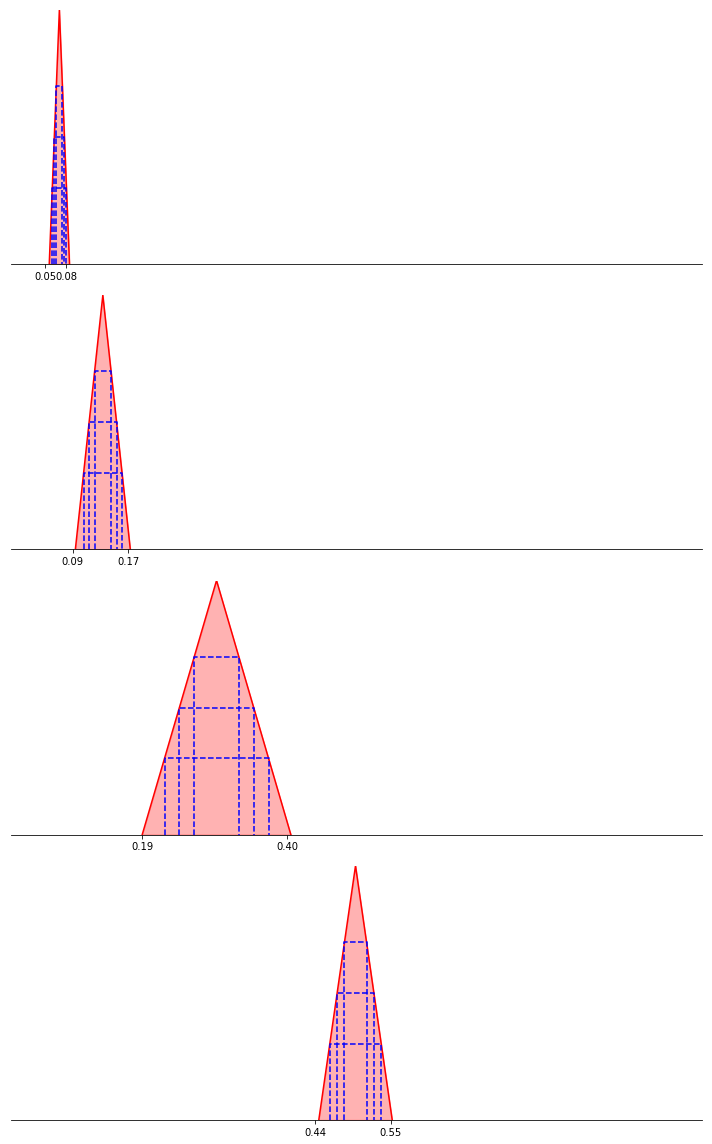

In [10]:
l = w_global[-1][0]
u = w_global[-1][1]
m = (l + u) / 2
draw_vector(l, m, u, alphas=[0.3, 0.5, 0.7])

## Висновки по роботі

Робота складалася із трьох частин.

У <b>першій частині</b> лабораторної роботи було побудовано мультиплікативну матрицю парних порівнянь відповідно до умови Задачі №6 (інвестор, що розглядає можливі зміни цін акцій).

У <b>другій частині</b> лабораторної роботи було побудовано мультиплікативну інтервальну матрицю парних порівнянь з матриці на першому кроці.

У <b>третій частині</b> лабораторної роботи було побудовано багаторівневу повну ієрархію Із (2-ма 3-ма, 4-ма) елементами на кожному із рівнів ієрархії відповідо.
Було розраховано глобальні ваги альтернатив на основі інтервальних матриць парних порівнянь на основі мультиплікативного методу синтезу для ІМПП.